## Enrichment of annotations for methylation probes

In [1]:
import NotebookImport
from DX_screen import *

importing IPython notebook from DX_screen

importing IPython notebook from Imports

importing IPython notebook from Global_Parameters

In [2]:
import MethylTools.Probe_Annotations as DX

importing IPython notebook from /cellar/users/agross/anaconda2/lib/python2.7/site-packages/MethylTools/Probe_Annotations

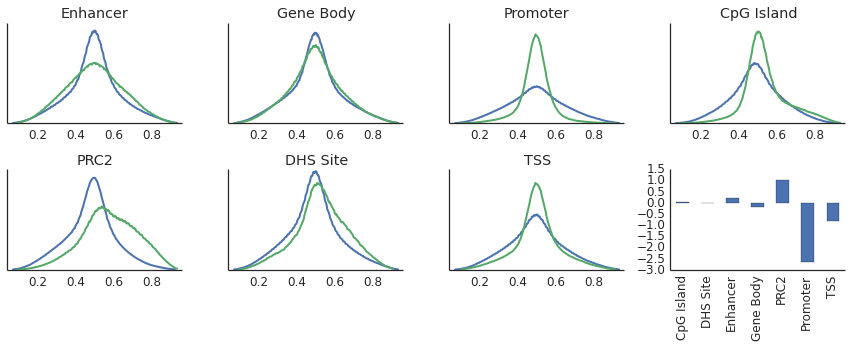

In [3]:
#Do not import
fig, axs = subplots(2,4, figsize=(12,5))
axs = axs.flatten()
for i,p in enumerate(DX.probe_sets.keys()):
    draw_dist(dx_meth.frac, DX.probe_sets[p], ax=axs[i])
    axs[i].legend().set_visible(False)
    axs[i].set_yticks([])
    axs[i].set_title(p)
    prettify_ax(axs[i])
f_odds = pd.DataFrame({f: fisher_exact_test((dx_meth.frac - .5).abs() > .25, v)
                      for f,v in DX.probe_sets.iteritems()}).T
np.log2(f_odds.odds_ratio).plot(kind='bar', ax=axs[-1])
prettify_ax(axs[-1])
fig.tight_layout()

In [4]:
def draw_dist_by_annotation(f, ax):
    lw = 2.5
    draw_dist(f.ix[ti(DX.probe_sets['Promoter'])], ax=ax, lw=lw)
    draw_dist(f.ix[ti(DX.probe_sets['CpG Island'])], ax=ax, lw=lw)
    draw_dist(f.ix[ti(DX.probe_sets['PRC2'])], ax=ax, lw=lw)
    draw_dist(f, ax=ax, colors='grey', lw=lw)
    ax.set_yticks([])
    ax.set_xticks([0,.5,1])
    ax.set_ylabel('Density')
    ax.set_xlabel('Fraction with Increased Methylation')
    ax.legend(('Promoter','CpG Island','PRC2','All Probes'))
    prettify_ax(ax)
    return ax

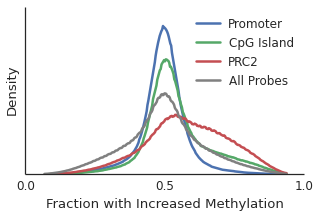

In [5]:
#Do not import
fig, ax = subplots(1,1, figsize=(5,3))
draw_dist_by_annotation(dx_meth.frac, ax);

This seems as though most of the PRC2 effect is probes with low methylation levels increasing in cancer.

In [6]:
mm = matched_meth.xs('11',1,1).mean(1)

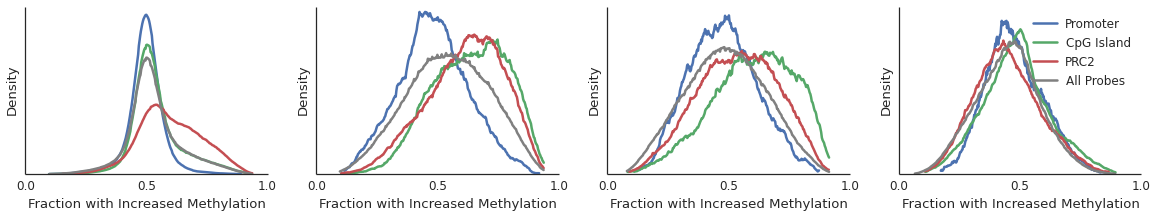

In [7]:
fig, axs = subplots(1,4, figsize=(20,3))
draw_dist_by_annotation(dx_meth.frac.ix[ti(mm < .25)], axs[0]);
draw_dist_by_annotation(dx_meth.frac.ix[ti((mm < .5) & (mm > .25))], axs[1]);
draw_dist_by_annotation(dx_meth.frac.ix[ti((mm < .75) & (mm > .5))], axs[2]);
draw_dist_by_annotation(dx_meth.frac.ix[ti((mm > .75))], axs[3]);
for ax in axs[[0,1,2]]:
    ax.legend().set_visible(False)

### Taking a look at disorder in methylation 
* Here we call a probe disordered if it trends towards 50% methylation in the presence of the tumor  
* This follows from the guidelines of [Hannum et. al](http://www.ncbi.nlm.nih.gov/pubmed/23177740) and my paper in review (add link when published) 

In [8]:
fisher_exact_test(mm < .5, dx_meth.frac > .5)

odds_ratio    2.19
p             0.00
dtype: float64

It seems that everything is effected by entropy, but PRC2 sites in particular have a tendency to drift towards 50% methylation.

In [9]:
pd.DataFrame({s: fisher_exact_test(mm.ix[ti(v)] < .5, dx_meth.frac > .5)
              for s,v in DX.probe_sets.iteritems()}).T

,odds_ratio,p
CpG Island,1.53,3.32e-130
DHS Site,2.41,0.00e+00
Enhancer,2.62,0.00e+00
Gene Body,1.77,0.00e+00
PRC2,3.92,0.00e+00
Promoter,1.25,6.30e-14
TSS,2.20,0.00e+00


Here is a different view, where I look at the overlap of disordered probes and annotations. This test takes into  account the global background whereas the previous does not. It is clearer here that PRC2 sites are more succeptable to drift than promoters and TSS. 

In [10]:
a,b = match_series((mm < .5), (dx_meth.frac > .5))
disordered = a == b
disordered.value_counts()

True     236169
False    159891
dtype: int64

In [11]:
probe_sets = pd.DataFrame(DX.probe_sets)
screen_feature(disordered, fisher_exact_test, probe_sets.T)

,odds_ratio,p,q
PRC2,1.95,0.00e+00,0.00e+00
Promoter,0.51,0.00e+00,0.00e+00
Gene Body,0.84,4.84e-154,1.13e-153
TSS,0.83,1.51e-148,2.65e-148
CpG Island,1.20,3.35e-102,4.69e-102
DHS Site,1.15,3.41e-48,3.98e-48
Enhancer,1.10,1.09e-33,1.09e-33


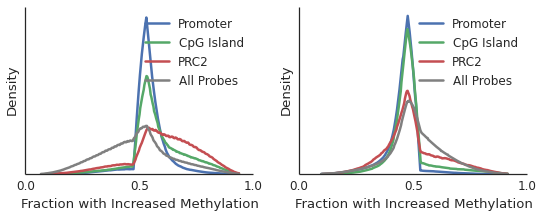

In [12]:
fig, axs = subplots(1,2, figsize=(9,3))
draw_dist_by_annotation(dx_meth.frac.ix[ti(disordered)], axs[0])
draw_dist_by_annotation(dx_meth.frac.ix[ti(disordered == False)], axs[1])

### GSEA on disordered probes

In [13]:
ann = DX.probe_annotations

In [14]:
d = dx_meth.frac.ix[ti(disordered == False)].dropna()
d.name = 'd'
dd = ann.join(d).sort('d').dropna()
vec = dd.set_index('Gene_Symbol')['d']

gs2 = gene_sets.ix[vec.index].fillna(0)
r2 = screen_feature(vec, rev_kruskal, gs2.T, 
                    align=False)

In [15]:
r2.head(6)

,H,p,q
PID_RHOA_REG_PATHWAY,190.18,2.91e-43,3.87e-40
KEGG_ENDOCYTOSIS,154.92,1.46e-35,9.70e-33
REACTOME_METABOLISM_OF_RNA,145.15,1.99e-33,7.92e-31
KEGG_NOTCH_SIGNALING_PATHWAY,144.79,2.38e-33,7.92e-31
REACTOME_TRANSLATION,143.23,5.25e-33,1.38e-30
PID_MET_PATHWAY,142.89,6.22e-33,1.38e-30


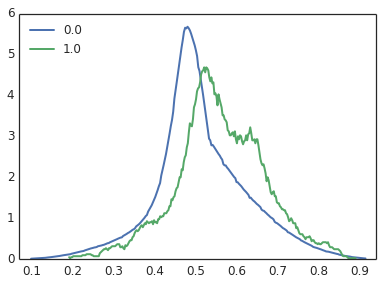

In [16]:
draw_dist(vec, gs2['PID_RHOA_REG_PATHWAY'])

__TODO__: Split by CpG Island, PRC2, Promoter, ect and do GSEA